# Computing Excess Monthly Stock Returns

This is a simple example of how to download stock price data and compute monthly excess stock returns using Python.

To download stock price data, we will use the `yfinance` library. Make sure that you have the latest `yfinance` library installed, otherwise the download will not work. You can install it and/or upgrade it using pip if you haven't already:

```bash
pip install yfinance --upgrade
```

The first step is to import `yfinance` and `pandas`. In this notebook I use `yfinance` to download stock price data for a specific ticker symbol and `pandas` to save the data to a XLSX file.

If you are using this notebook locally, you need to have the package `openpyxl` installed if you want to download the Pandas dataframe as an Excel spreadsheet. To do that, run

```bash
pip install openpyxl --upgrade
```

If you are using Google Colab the latest `yfinance` package and `openpyxl` should be installed and ready to use.

In addition, I like to disable some warnings from `yfinance` that are annoying but not important. The library `yfinance` has sustained important changes recently, and the warnings are related to those changes.

In [81]:
import yfinance as yf
import pandas as pd

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

The next code block downloads stock price data for several ticker symbols. In `yfinance`, you can specify multiple ticker symbols by defining a list of strings. In the example, I download data for Tesla (TSLA), Apple (AAPL), and the S&P 500 ETF (SPY). I start the data from September 1, 2020, and end it on September 30, 2025.

I select only the adjusted closing prices of the stocks using `.loc[:, 'Close']`. In the latest version of `yfinance`, the 'Close' column contains the adjusted closing prices.

The data is downloaded at a daily frequency, and then resampled monthly. In `yfinance`, there is an option to define the interval. But if you select `interval='1mo'` then you only get the first of each month and many observations for '^IRX' are empty. So it's better to use the built-in functionality of `pandas` and resample the dataframe monthly using `.resample('ME').last()`. The 'ME' means month-end frequency in the latest version of `pandas`. I then pick the last observation of each month using `.last()`.

Finally, in investments we are typically interested in total returns rather than prices. We can easily convert each price column into a monthly return by using the function `pct_change()`.




In [82]:
tickers = ['TSLA', 'AAPL', 'SPY']

df = (
    yf.download(
        tickers=tickers,
        start='2020-09-01',
        end='2025-09-30',
        progress=False,
    )
    .loc[:, 'Close']
    .resample("ME")
    .last()
    .pct_change()
    .dropna()
)

It's a good idea to take a look at the data first.

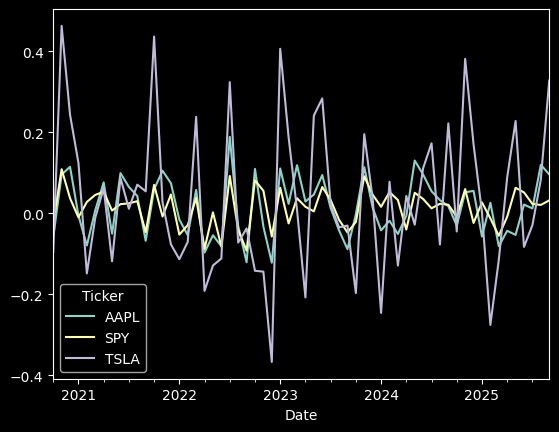

In [83]:
ax = df.plot()

We can also download the ticker symbol for the 3-month Treasury bill (^IRX) to use it as a proxy for the risk-free rate. Note that the series is expressed as a yearly percentage. For monthly returns computed as decimal, the right number to compute excess returns would be ^IRX / 12 /100. Note that I divide by 12 since money-market rates are typically expressed as simple interest per year.

In [84]:
rf = (
    yf.download(
        tickers=['^IRX'],
        start='2020-09-01',
        end='2025-09-30',
        progress=False,
    )
    .loc[:, 'Close']
    .resample("ME")
    .last()
    .dropna()
    .assign(RF=lambda x: x['^IRX'] / 12 / 100)
    .drop(columns=['^IRX'])
)

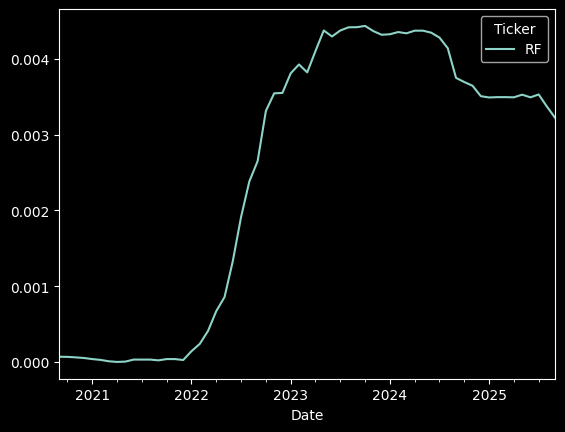

In [85]:
ax = rf.plot()

We can subtract the risk-free rate in `rf` from each column in `df` to obtain excess returns over the risk-free rate.

In [86]:
excess_returns = df.sub(rf['RF'], axis=0).dropna()
excess_returns.head()

Ticker,AAPL,SPY,TSLA
Date,,,
2020-10-31,-0.060081,-0.025003,-0.095568
2020-11-30,0.095431,0.108714,0.462673
2020-12-31,0.114519,0.036994,0.243198
2021-01-31,-0.005541,-0.010230,0.124466
2021-02-28,-0.079741,0.027776,-0.148770


Finally, save the dataframe `excess_returns` to Excel.

In [87]:
excess_returns.to_excel("excess_returns.xlsx", sheet_name="Sheet1")